# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy / Log Loss
3. Misclassification Error

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [54]:
# your code here
def entropy(label):
    counts = np.unique(label,return_counts = True)
    N = float(label.shape[0])

    ent = 0.0
    ##counts [0,1] [2, 5], tuple_values = 0,1 : freq=2,5
    for val in counts[1]:
        pb = val / N ##find prob for each unique val
        ent += (-1*pb*np.log2(pb))

    return ent

def gini_index(y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

def information_gain(x_data,fkey,fval,mode="entropy"):
    ## x_dta to get all featurs
    ## split on basis of some key fkey, feature index
    ## fval threshold val jiske basis pe split binary split
    l_child , r_child = divide_data(x_data,fkey,fval) 

    # % of sample on left and right
    weight_l = float(l_child.shape[0]) / x_data.shape[0]
    weight_r = float(r_child.shape[0]) / x_data.shape[0]

    if mode=="gini":
        gain = gini_index(x_data) - (weight_l*gini_index(l_child) + weight_r*gini_index(r_child))
    else:
        gain = entropy(x_data) - (weight_l*entropy(l_child) + weight_r*entropy(r_child))
    return gain

    

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [55]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value


class SelfDecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [1]:
##lesss accurate code in git repo

In [56]:
# your code here
# features = ['variance', 'skewness', 'curtosis','entropy']
data = pd.read_csv('bankAuth.txt')
data.columns = ['variance', 'skewness', 'curtosis','entropy','labels']
data.head()


,variance,skewness,curtosis,entropy,labels
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [57]:
# your code here
from sklearn.tree import plot_tree
def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [58]:
data = pd.read_csv('bankAuth.txt')

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [59]:
# your code here
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

#SELF DECISION TREE



In [60]:
classifier = SelfDecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_0 <= 0.26877 ? 0.2622028665401259
 left:X_1 <= 7.5032 ? 0.13531109768091729
  left:X_0 <= -0.40804 ? 0.015882012166573423
    left:X_2 <= 6.2169 ? 0.006020023164857641
        left:1.0
        right:1.0
    right:X_2 <= 2.135 ? 0.1971049839068061
        left:1.0
        right:0.0
  right:X_0 <= -5.1661 ? 0.30055401662049874
    left:1.0
    right:0.0
 right:X_2 <= -4.4738 ? 0.03993645757594755
  left:X_0 <= 2.2279 ? 0.40816326530612246
    left:1.0
    right:0.0
  right:X_0 <= 1.581 ? 0.016750952439149147
    left:X_2 <= -2.3 ? 0.11506199737272113
        left:1.0
        right:0.0
    right:X_0 <= 2.031 ? 0.0008196897955161445
        left:0.0
        right:0.0


In [61]:
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
print("Accuracy score of decision tree:",accuracy_score(Y_test, Y_pred))

Accuracy score of decision tree: 0.9527272727272728


### Using Decision tree classifier
USING SKLEARN DECISION TREE CLASSIFIER

In [62]:
# your code here
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 

X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test


## USING GINI


In [63]:
clf_gini = DecisionTreeClassifier(criterion = "gini")
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_test)
print("Accuracy score of decision tree:",accuracy_score(y_test,y_pred)*100)

Accuracy score of decision tree: 98.7864077669903


In [64]:
clf= DecisionTreeClassifier(criterion = "gini", random_state = 100,
            max_depth = 3, min_samples_leaf = 5)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score of decision tree:",accuracy_score(y_test,y_pred)*100)


Accuracy score of decision tree: 93.20388349514563


### PLOT TREE

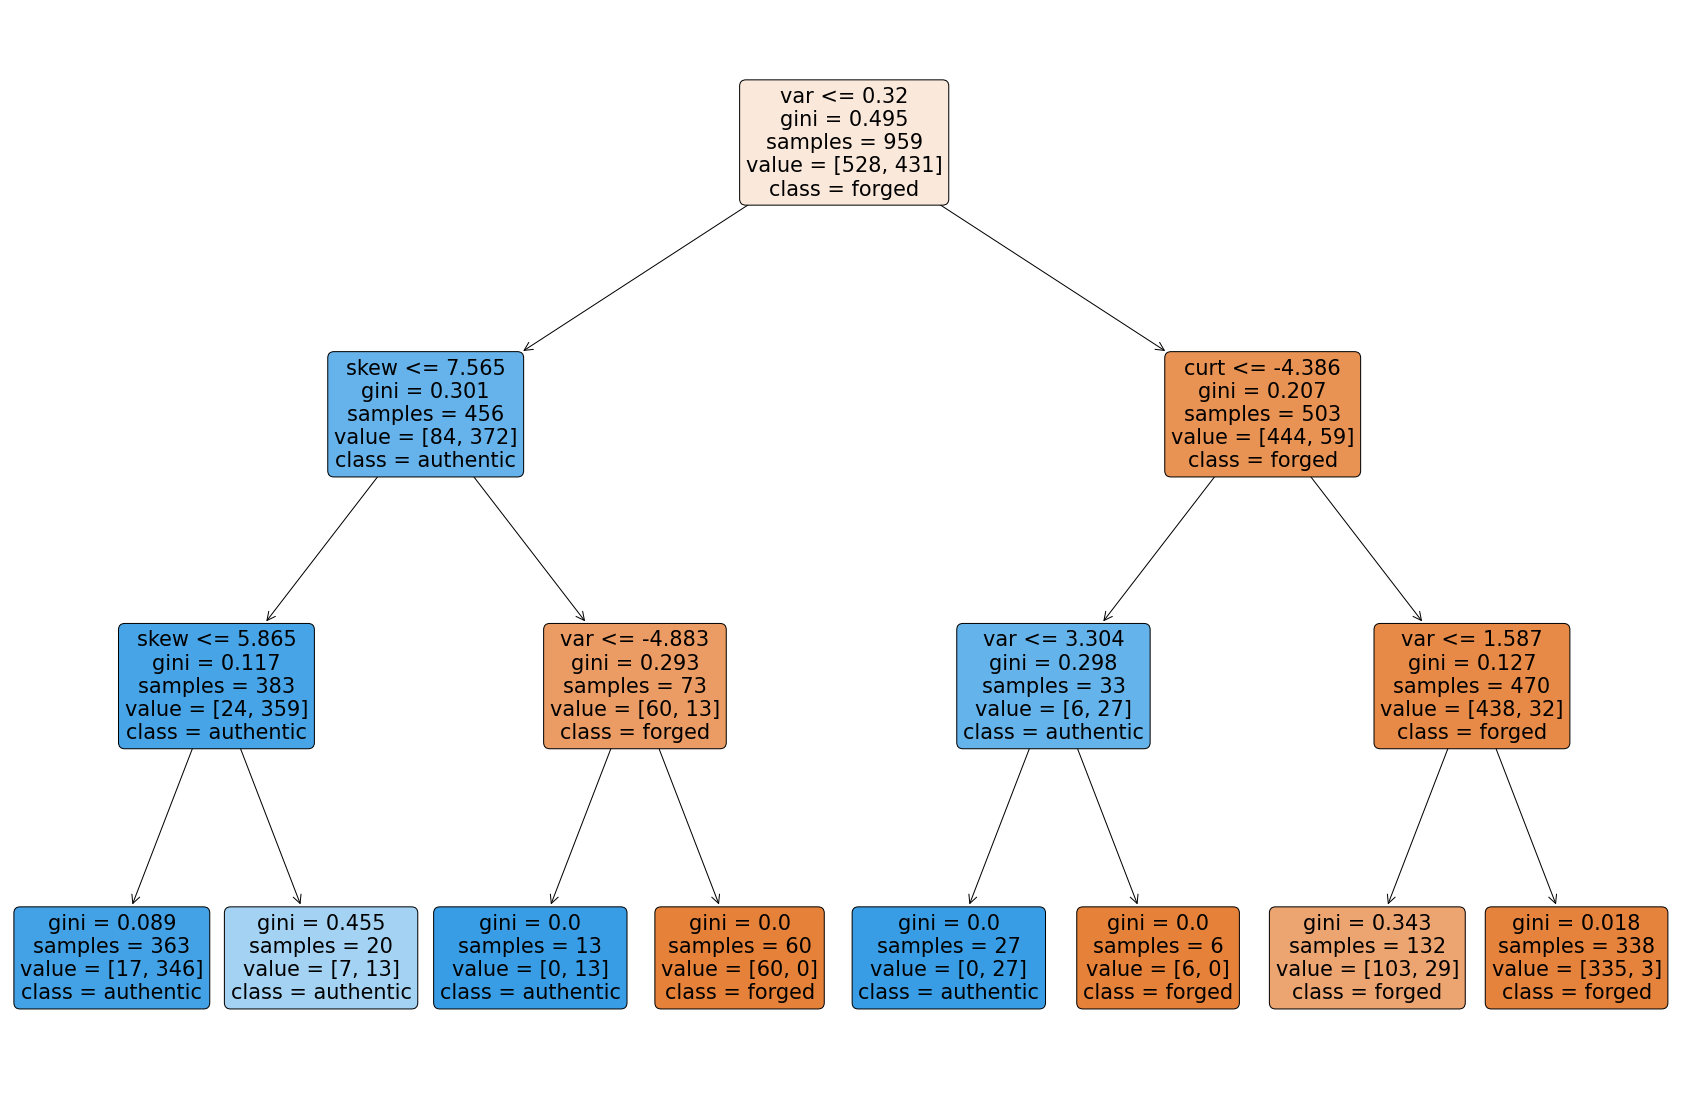

In [65]:
plotTree(clf)

### Using  entropy

In [66]:
clf= DecisionTreeClassifier(criterion = "entropy")
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score of decision tree:",accuracy_score(y_test,y_pred)*100)


Accuracy score of decision tree: 99.02912621359224


In [67]:
clf= DecisionTreeClassifier(criterion = "entropy", random_state = 100,
            max_depth = 3, min_samples_leaf = 5)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score of decision tree:",accuracy_score(y_test,y_pred)*100)


Accuracy score of decision tree: 94.66019417475728


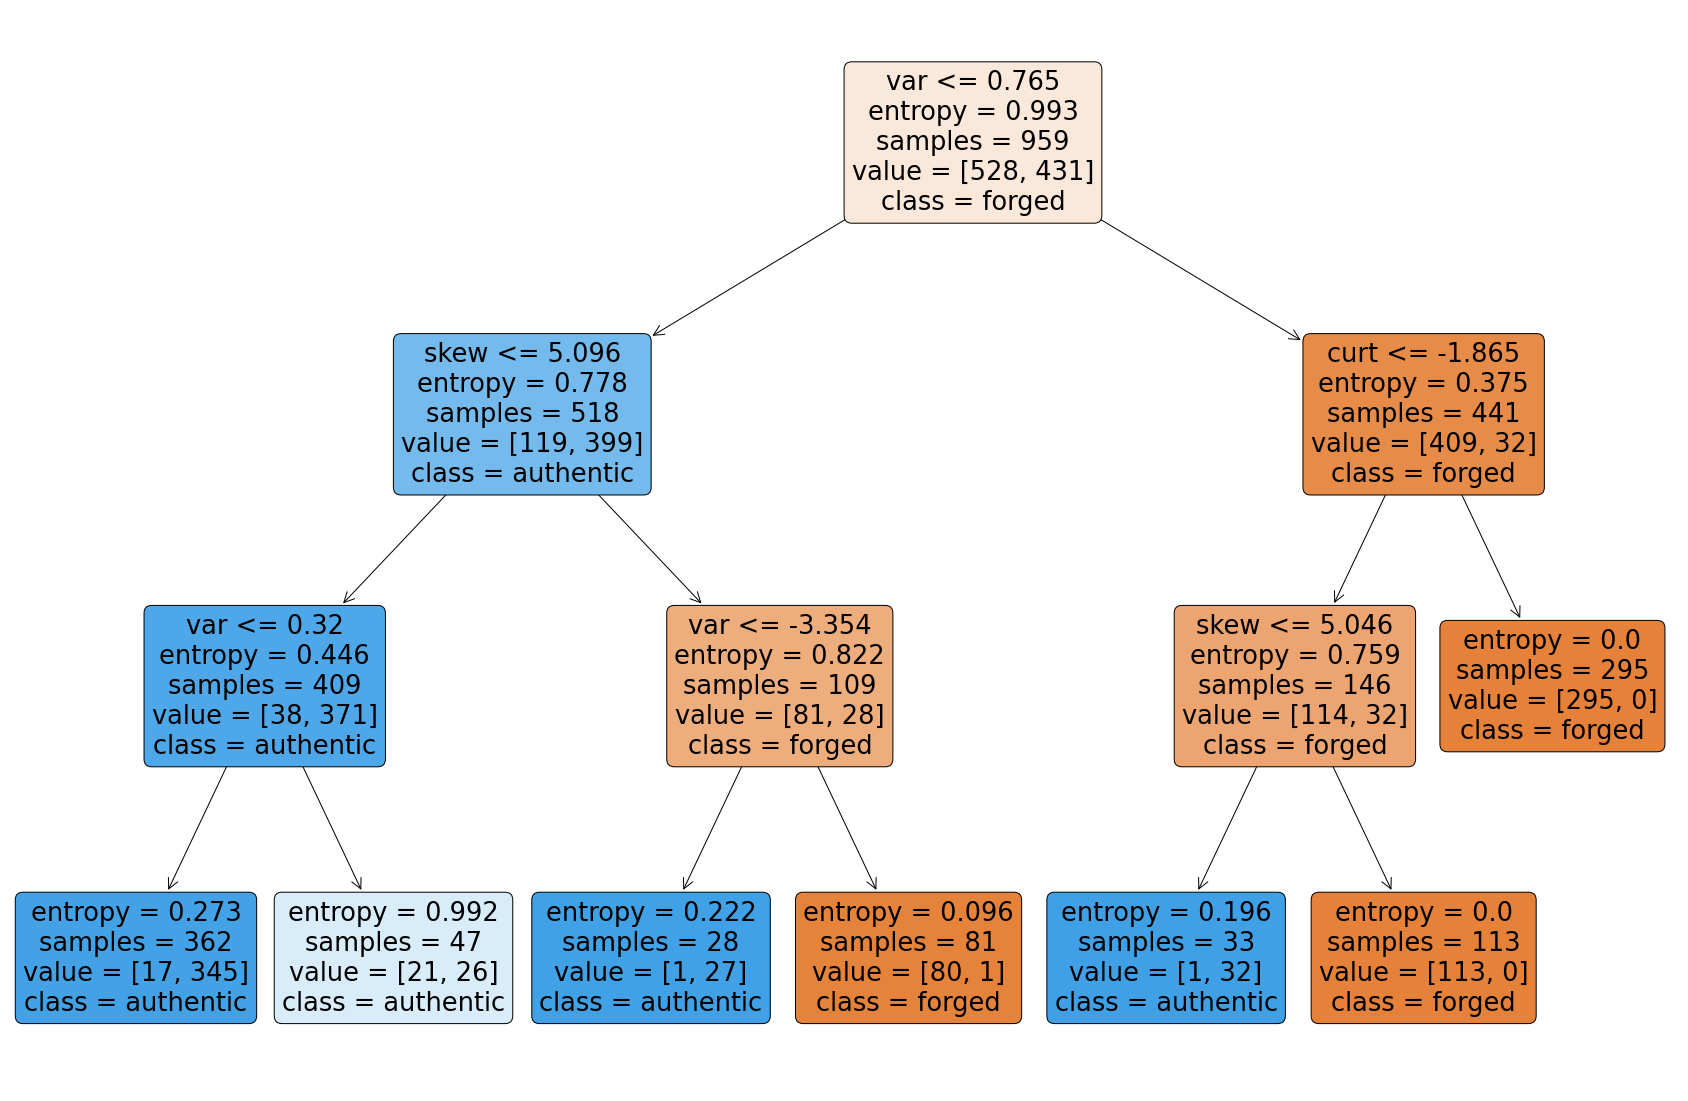

In [68]:
## PLOTING TREE
plotTree(clf)
